#**Proyecto Final: Etapa 2**

**Desarrollo del Prototipo Computacional y Documentación Técnica**

Nicolás Gajardo Sepúlveda

**Descripción general:** Este Notebook desarrolla los modelos de aprendizaje supervisado para abarcar la problemática de reducción del esfuerzo computacional en ejecutar simulaciones hidráulicas para evaluar la viabilidad de soluciones de diseño y operación de Estaciones de Bombeo (EB) en Redes de Distribución de Agua (RDA)

En este proyecto se encuentran la generación de dos modelos de aprendizaje automático para formar un sistema de dos capas de evaluación. La primera capa consta de un modelo de clasificación para estimar la factibilidad de las configuraciones de diseño y operación de EB, mientras que la segunda capa contiene un modelo de regresión que estima las presiones de operación de cada EB en base al caudal suministrado en período de operación

**Contenido:**
- **1. Carga de datos sintéticos**
- **2. Procesamiento de datos**
- **3. Análisis exploratorio con visualizaciones**
- **4. Aplicación de dos modelo de Machine Learning, clasificación y regresión**
- **5. Evaluación de resultados y desempeño de los modelos**

##1. Carga de Datos sintéticos##
Sección dedicada a la carga de datos sintéticos a partir del repositorio de Github , en conjunto con una exploración inicial de la base elaborados con simulaciones hidráulicas. Contiene:
- Las columnas disponibles y sus tipos de datos.
- Las estadísticas descriptivas de las variables numéricas.
- Análisis de valores faltantes.

La base sintética consiste en Caudales (Q) y Presiones (H) suministrados en cada periodo (T) por cada EB, estableciendo EB1 y EB2 para el caso de estudio actual. Tambien cuenta con caracteristicas de las bombas a instalar: A coeficiente de perdida, H0 presión o altura máxima que puede suministrar, Qmax caudal máximo de operación, y Rmax rendimiento o eficiencia máxima. Por último, cada instancia cuenta con una etiqueta de factibilidad (0=Factible, 1=No factible) y costos totales (EUR)

In [2]:
import csv
import pandas as pd

#Dirección de la base sintética en el repositorio entregado
url = "https://raw.githubusercontent.com/NicoGajardo/Proyecto_Final_Etapa2/main/Base_Sintetica.csv"
df = pd.read_csv(url, index_col=0, sep=";")
print(df.head())

print("COLUMNAS DEL DATASET:")
print(df.info())
print("")
print("ESTADÍSTICAS DEL DATASET:")
print(df.describe())
print("")
print("VALORES FALTANTES DEL DATASET:")
print(df.isnull().sum())

               T1-Q1      T2-Q1      T3-Q1      T4-Q1      T5-Q1      T6-Q1  \
Instancia                                                                     
1          71.372482  68.948296  55.696213  64.117561  57.284287  72.045822   
2          68.278870  52.600243  45.362801  44.226479  52.720051  51.414070   
3          60.964241  49.543163  39.340286  46.919590  49.108601  55.394234   
4          53.975811  44.353592  46.588329  48.885696  48.117695  54.259300   
5          52.289330  50.738476  46.293137  46.073517  44.013206  52.745491   

               T7-Q1       T8-Q1       T9-Q1      T10-Q1  ...     T17-H2  \
Instancia                                                 ...              
1          97.249763  139.528626  135.714935  143.748550  ...  13.254770   
2          69.978508  105.024658   89.646500   95.916901  ...  86.733612   
3          60.814095  107.167000   94.294212   94.712875  ...  45.420155   
4          71.352112   83.268181   86.035576   87.131287  ...  97.

##2. Procesamiento de datos ##

Prepararlos el conjunto de datos para el entrenamiento de ambos modelos de machine learning. Sección de preprocesamiento:

1. **Eliminar columnas innecesarias**: La columna de `Costo Total` no es el target de los modelos ni será utilizado en el entrenamiento.

2. **Separar entradas y salidas para ambos modelos**: Se asignan los conjuntos de entrenamiento y conjuntos objetivo tanto de regresión como de clasificación.

3. **Balacear las clases para la clasificación**: La columna de factibilidad tiene un desbalance debido al gran número de soluciones no factibles en el diseño y operación de redes de distribución de agua, por lo que se emplea una técnica de balanceo SMOTE.

4. **Estandarización de variables**: Las variables numéricas son estandarizadas para analizar en una escala común a los valores de la base y mejorar la eficiencia de entrenamiento.

In [3]:
# 1. Eliminar columna innecesaria
df = df.iloc[:, :-1]

In [5]:
# 2. Separar atributos de entrada y objetivos de salida de los modelos

# Atributos de entrada
#input_columns = df.loc[:, 'T1-Q1':'RMAX2'].columns
#X = df[input_columns]

input_columns = df.loc[:, 'T1-Q1':'T24-Q2'].columns
X_Q = df[input_columns]

# Target de regresión
target_columns = df.loc[:, 'T1-H1':'T24-H2'].columns
y_regresion = df[target_columns]

# Target de clasificación
y_clasificacion = df['Factibilidad']

print("Shapes de X e y:")
print("Shape X (Inputs):", X_Q.shape)
print("Shape y regresion (Targets):", y_regresion.shape)
print("Shape y clasificacion (Targets):", y_clasificacion.shape)

Shapes de X e y:
Shape X (Inputs): (5000, 48)
Shape y regresion (Targets): (5000, 48)
Shape y clasificacion (Targets): (5000,)


In [6]:
from imblearn.over_sampling import SMOTE

# 3. Balacear las clases para la clasificación

# Analisis de distribución de etiquetas
print("Distribución original de valores objetivo:")
print(df['Factibilidad'].value_counts())

# Implementación de SMOTE
smote = SMOTE(random_state=42)
X_clasificacion_s, y_clasificacion_s = smote.fit_resample(X_Q, y_clasificacion)

print("Nueva distribución de valores objetivo:")
print(y_clasificacion_s.value_counts())


Distribución original de valores objetivo:
Factibilidad
1    4442
0     558
Name: count, dtype: int64
Nueva distribución de valores objetivo:
Factibilidad
0    4442
1    4442
Name: count, dtype: int64


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Identificar las columnas numéricas en X
colum_num = X_Q.select_dtypes(include=['number']).columns

# Generar copias para no modificar los datos originales
X_regresion_scaled = X_Q.copy()
X_clasificacion_scaled = X_clasificacion_s.copy()

#Estandarizar columnas numéricas en los atributos X
X_regresion_scaled[colum_num] = scaler.fit_transform(X_regresion_scaled[colum_num])
X_clasificacion_scaled[colum_num] = scaler.fit_transform(X_clasificacion_scaled[colum_num])

print("Datos estandarizados (Regresión):")
print(X_regresion_scaled.head())
print("Datos estandarizados (Clasificación):")
print(X_clasificacion_scaled.head())


Datos estandarizados (Regresión):
              T1-Q1     T2-Q1     T3-Q1     T4-Q1     T5-Q1     T6-Q1  \
Instancia                                                               
1          1.839933  2.599714  1.204977  1.773271  1.673525  3.196603   
2          1.419343  0.061014 -0.411736 -0.675851  0.846861  0.135579   
3          0.424887 -0.413722 -1.353988 -0.344257  0.192763  0.726095   
4         -0.525221 -1.219614 -0.219996 -0.102177  0.013292  0.557711   
5         -0.754506 -0.228101 -0.266181 -0.448431 -0.730104  0.333115   

              T7-Q1     T8-Q1     T9-Q1    T10-Q1  ...    T15-Q2    T16-Q2  \
Instancia                                          ...                       
1          2.841266  2.314960  2.643589  2.295933  ... -2.566666 -2.267681   
2         -0.026364  0.166106 -0.690622 -0.654486  ... -0.857696  1.980670   
3         -0.990022  0.299528 -0.354243 -0.728754  ...  0.743802 -0.624930   
4          0.118073 -1.188854 -0.951963 -1.196412  ...  1.484010

##3. Análisis exploratorio con visualizaciones##

Visualización de los datos a travez de gráficos de correlación.

1. **Mapa de correlación**: Visualización de los atributos estandarizados y no estandarizados.

2. **Gráficos de correlación**: A partir de la visualización de atributos con mayor correlación, se observa un ejemplo del comportamiento lineal en la correlación entre T6-Q2 y T6-Q1, con datos estandarizados y no estandarizados.



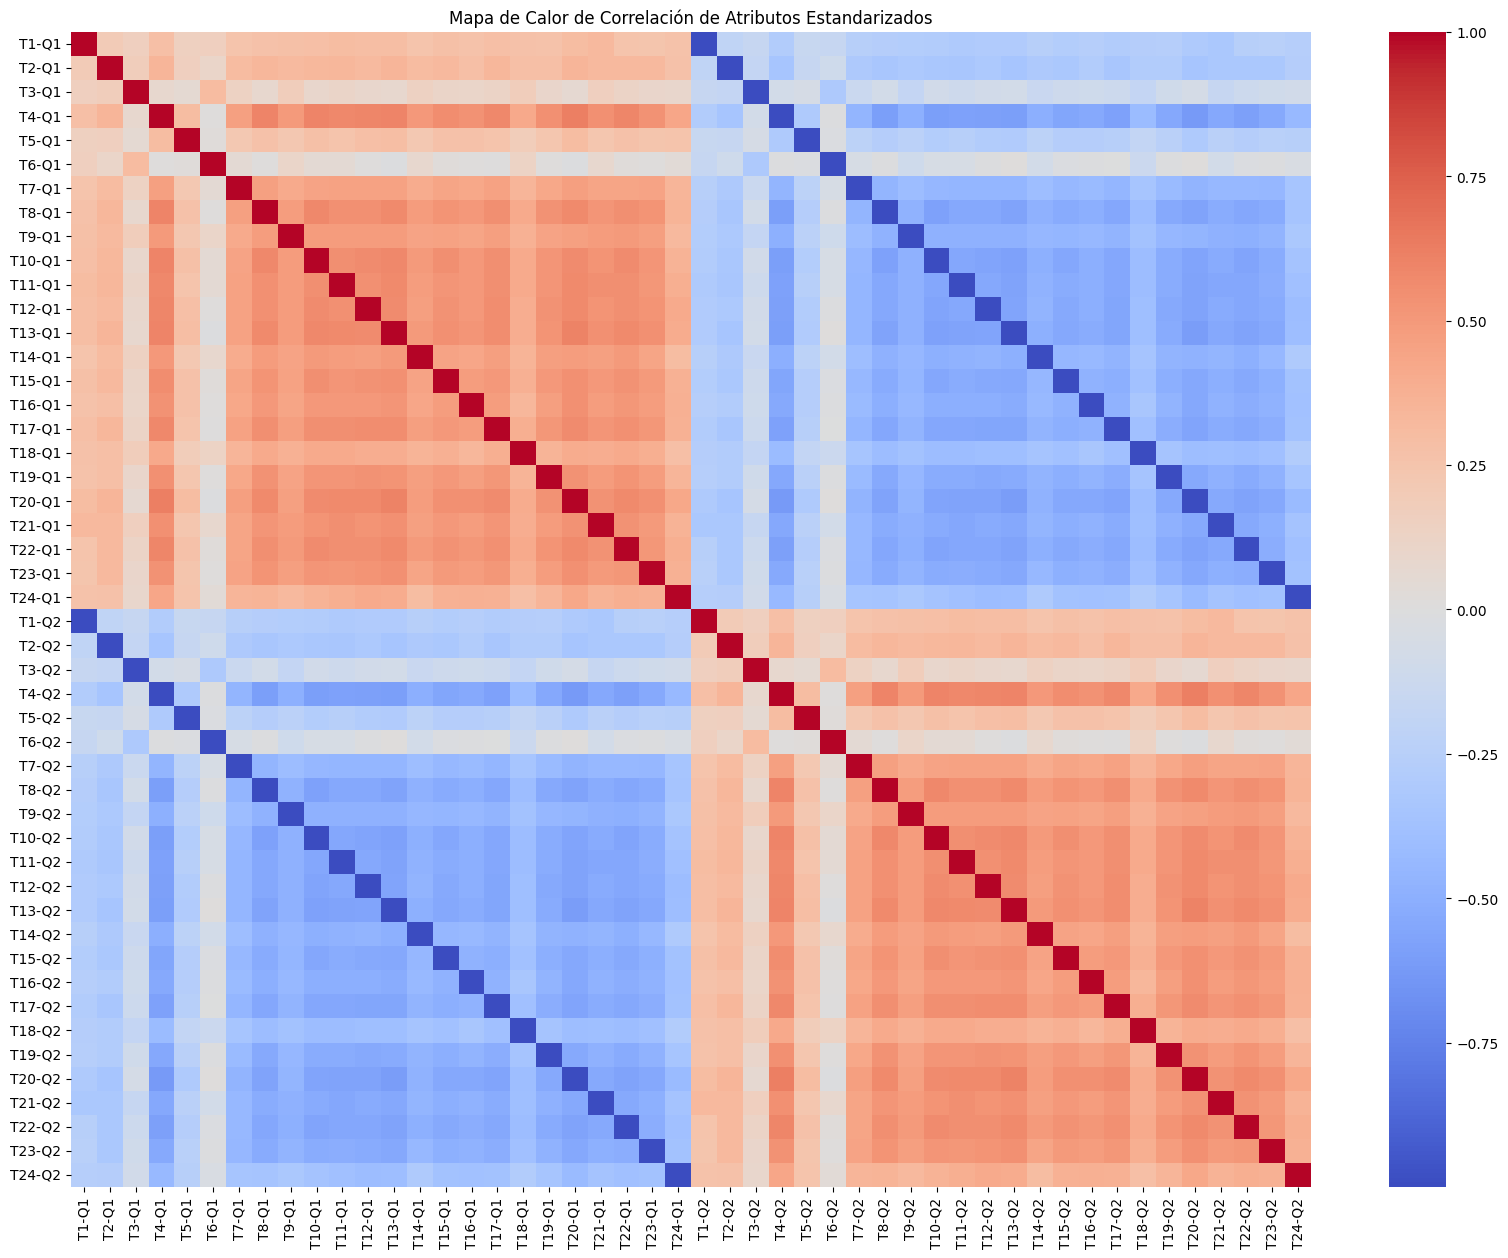

In [8]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
seaborn.heatmap(X_regresion_scaled.corr(), annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación de Atributos Estandarizados')
plt.show()

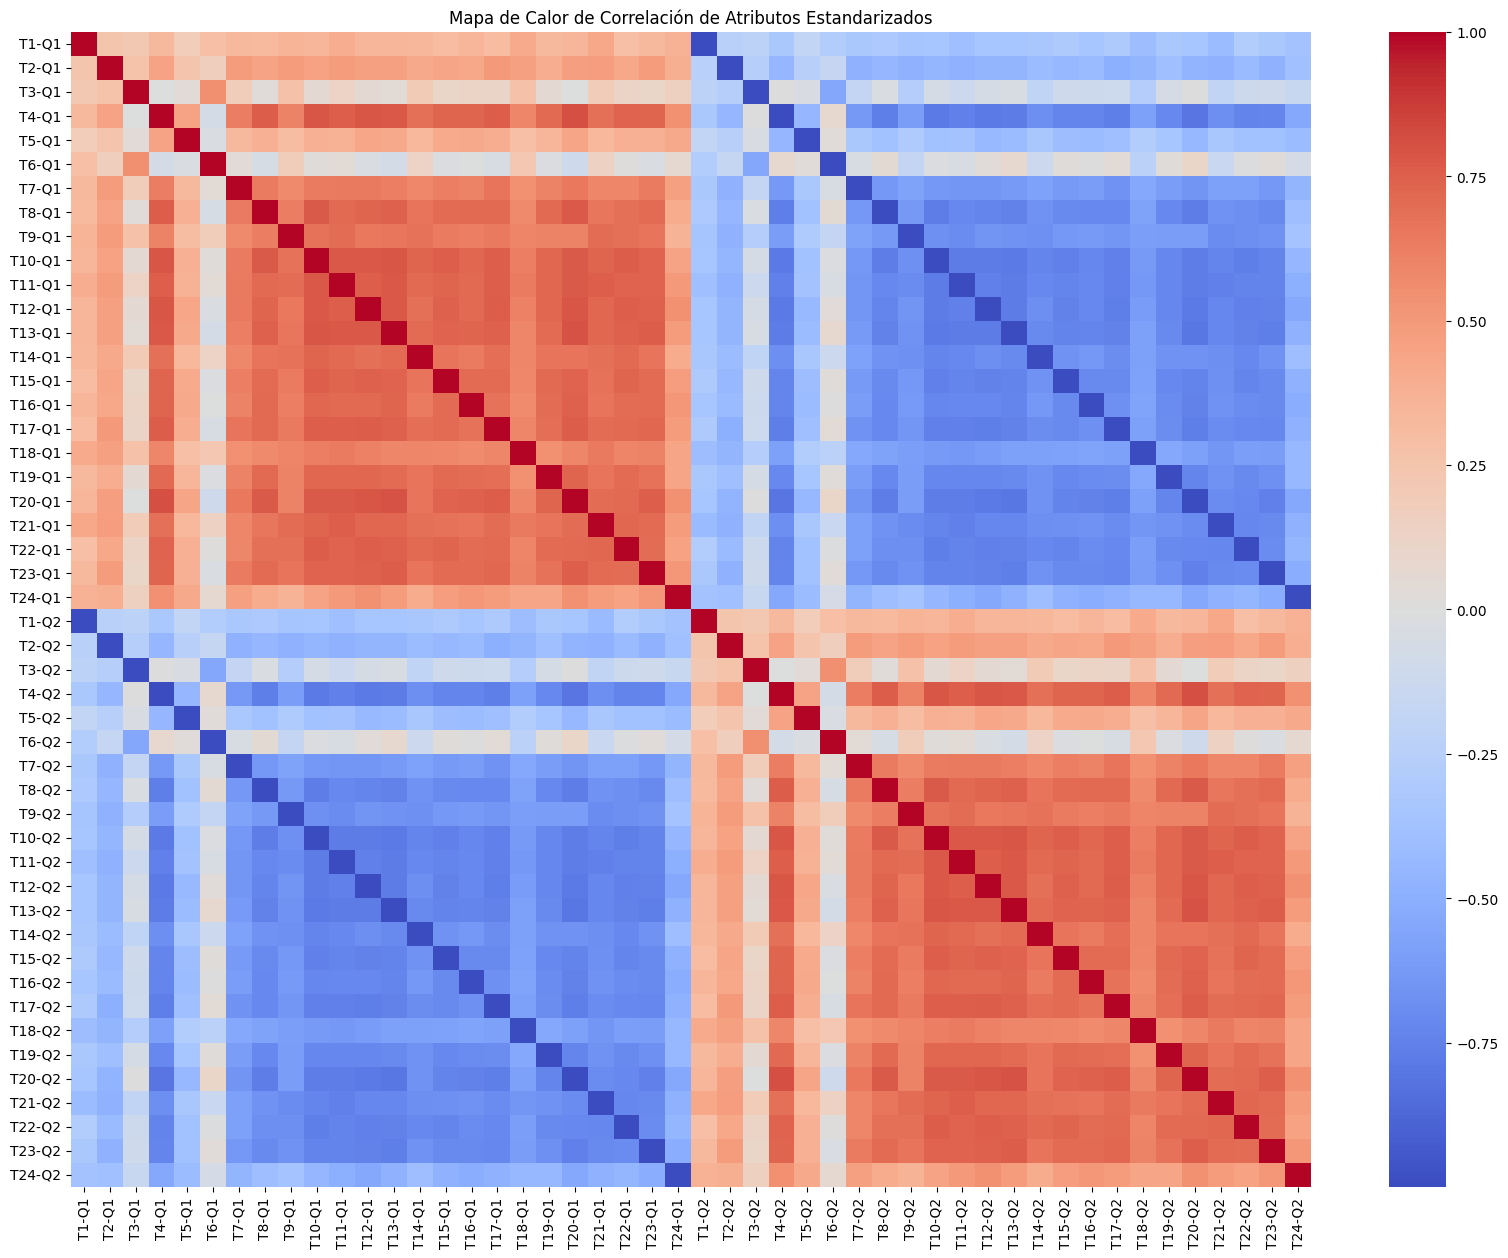

In [9]:
plt.figure(figsize=(20, 15))
seaborn.heatmap(X_clasificacion_scaled.corr(), annot=False, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación de Atributos Estandarizados')
plt.show()

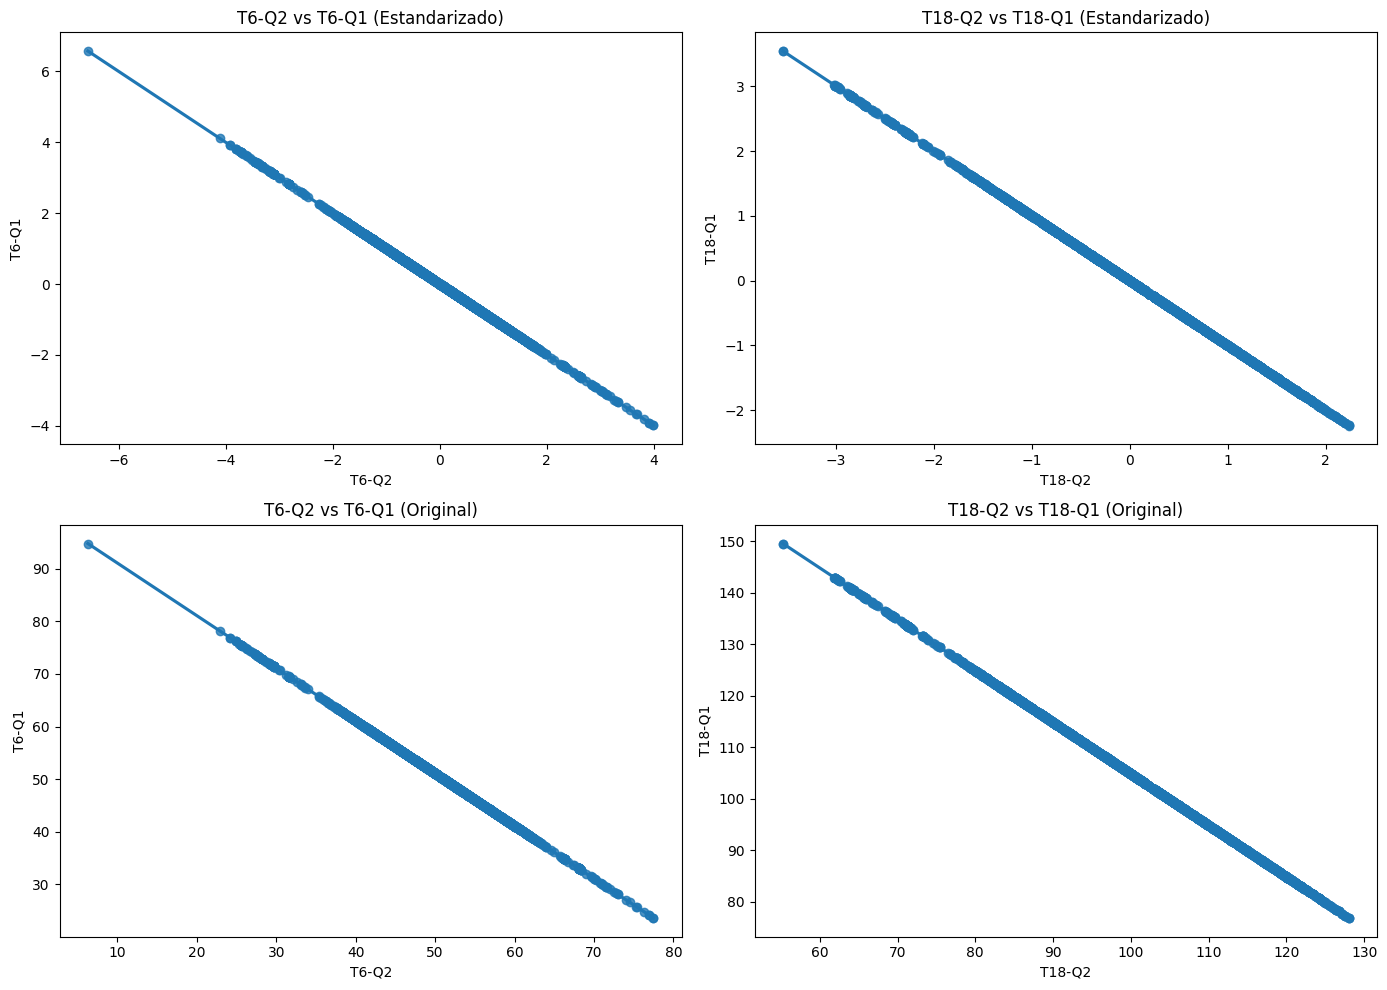

In [10]:
# Gráfica de correlación
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2 filas, 2 columnas

seaborn.regplot(x='T6-Q2', y='T6-Q1', data=X_regresion_scaled, ax=axs[0, 0])
axs[0, 0].set_title("T6-Q2 vs T6-Q1 (Estandarizado)")

seaborn.regplot(x='T18-Q2', y='T18-Q1', data=X_regresion_scaled, ax=axs[0, 1])
axs[0, 1].set_title("T18-Q2 vs T18-Q1 (Estandarizado)")

seaborn.regplot(x='T6-Q2', y='T6-Q1', data=X_Q, ax=axs[1, 0])
axs[1, 0].set_title("T6-Q2 vs T6-Q1 (Original)")

seaborn.regplot(x='T18-Q2', y='T18-Q1', data=X_Q, ax=axs[1, 1])
axs[1, 1].set_title("T18-Q2 vs T18-Q1 (Original)")

plt.tight_layout()
plt.show()

##Análisis:##
- El mapa de calor ilustra bloques bien definidos de correlaciones positivas y negativas: El bloque superior izquierdo denota correlaciones positivas entre atributos pertenecientes a los caudales (Q) de EB1 para todo periodo de operación. De manera similar, el bloque inferior derecho presenta alta correlación entre Q de la EB2. Se destacan correlaciones negativas fuertes entre pares cruzados de Q1 y Q2 que pertenezcan al mismo periodo, esto principalmente debido al patrón de demanda que deben seguir las EB en cada periodo.

- Los gráficos de correlación ilustran fuertes relaciones negativas. En este caso las relaciones T6-Q2 vs T6-Q1 y T18-Q2 vs T18-Q1 fueron seleccionadas de forma arbitraria. Las nubes de puntos completamente alineadas sobre una recta descendente confirma la alta colinealidad negativa entre estos atributos. Esto se debe principalmente al cumplimiento de la demanda de cada periodo. Los suministros de EB1 corresponden al complemento del caudal de EB2 para llegar a a la demanda del periodo, esto replicable para cada par de caudales del mismo periodo.

- Esta visualización puede inducir en redundancias en los atributos. Algunas correlaciones fuertes sugieren que hay atributos que podrían ser eliminados sin pérdida significativa de información. Al mismo tiempo, ciertos casos y atributos pueden derivar en nuevas variables sintéticas que resuman mejor la información.

##4. Aplicación de modelo de Machine Learning, clasificación y regresión ##

Implementación de modelos de aprendizaje automático. Optimización de parámetros a travez de busqueda de rejilla con reducción progresiva (Halving grid search). Evaluación del desempeño de los modelos con k-fold cross-validation (k=5).

**1. Modelo de regresión de presiones:** Implementación de modelo Multi-layer perceptron (ANN para regresión) con multiples salidas. Metricas de evaluación:
  - Error Absoluto Medio
  - Error cuadrático medio
  - Error porcentual absoluito medio
  - Correlación R2

**2. Modelo de clasificación de factibilidad:** Implementación de modelo de Arbol de decisión (Decision Tree Classifier). Metricas de desempeño:
  - Precisión
  - Recall
  - F1-score

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, HalvingGridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, f1_score

# 1. Modelo de regresión, estimación de parámetros de presión de las estaciones de bombeo: MLPRegressor

mlp = MLPRegressor(max_iter=1000, random_state=42)

# Optimización de hiperparámetros

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
}

"""
search = HalvingGridSearchCV(mlp, param_grid_mlp,
                              resource='n_samples',
                              min_resources='smallest').fit(X_regresion_scaled, y_regresion)

# Modelo con parámetros optimizados
regr = MLPRegressor(solver='adam',
                    alpha=search.best_params_['alpha'],
                    hidden_layer_sizes=search.best_params_['hidden_layer_sizes'],
                    activation=search.best_params_['activation'])
"""

# MEJORES PARÁMETROS
# Se insertan los mejores parámetros directamente para no realizar la busqueda optimización de hiperparámetros.
# Aún así, generar el modelo toma tiempo.
#{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50)}

regr = MLPRegressor(solver='adam',
                    alpha=0.01,
                    hidden_layer_sizes=(100, 50),
                    activation='relu')

multi_mlp = MultiOutputRegressor(regr)


# Evaluación con K-Fold Cross-Validation
Folds = 5

data = cross_validate(multi_mlp, X_regresion_scaled, y_regresion, cv=Folds,
                              scoring=('neg_mean_absolute_error',
                                       'neg_mean_squared_error',
                                       'neg_mean_absolute_percentage_error',
                                       'r2'),
                              return_train_score=True)
MetricasMultiLayerPerceptron = pd.DataFrame(data)

#print(' Metricas de evaluación Multi Layer Perceptron: ')
#print(MetricasMultiLayerPerceptron)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# 2. Modelo de clasificación, estimación de factibilidad de soluciones de diseño y operación de estaciones de bombeo: Decision Tree Classifier

dtc = DecisionTreeClassifier(random_state=42)

# Optimización de hiperparámetros
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search = HalvingGridSearchCV(dtc, param_grid_dtc,
                              resource='n_samples',
                              min_resources='smallest').fit(X_clasificacion_scaled, y_clasificacion_s)

# Modelo con parámetros optimizados
fact_clas = DecisionTreeClassifier(criterion=search.best_params_['criterion'],
                              max_depth=search.best_params_['max_depth'],
                              min_samples_split=search.best_params_['min_samples_split'],
                              min_samples_leaf=search.best_params_['min_samples_leaf'])

# Evaluación con K-Fold Cross-Validation
Folds = 5

scoring_metrics = {'precision': make_scorer(precision_score, zero_division=0),
                  'recall': make_scorer(recall_score, zero_division=0),
                  'f1': make_scorer(f1_score, zero_division=0)
}

data = cross_validate(fact_clas, X_clasificacion_scaled, y_clasificacion_s, cv=Folds,
                              scoring=scoring_metrics,
                              return_train_score=True)

MetricasDecisionTreeClassifier = pd.DataFrame(data)

#print(' Metricas de clasificación Decision Tree Classifieir: ')
#print(MetricasDecisionTreeClassifier)

 Metricas de clasificación Decision Tree Classifieir: 
   fit_time  score_time  test_precision  train_precision  test_recall  \
0  0.430186    0.012177        0.980834         0.997741     0.979730   
1  0.433777    0.010664        0.993182         0.998870     0.984234   
2  0.408135    0.010754        0.995449         0.998024     0.984252   
3  0.422380    0.011020        0.995449         0.998584     0.984252   
4  0.435485    0.010658        0.994337         0.997463     0.988739   

   train_recall   test_f1  train_f1  
0      0.994091  0.980282  0.995913  
1      0.995217  0.988688  0.997040  
2      0.994934  0.989819  0.996476  
3      0.992682  0.989819  0.995625  
4      0.995779  0.991530  0.996621  
Precision por pliegue: [0.98083427 0.99318182 0.99544937 0.99544937 0.99433749]
Recall por pliegue: [0.97972973 0.98423423 0.98425197 0.98425197 0.98873874]
F1-score por pliegue: [0.98028169 0.98868778 0.989819   0.989819   0.99153021]


##5. Evaluación de resultados y desempeño de los modelos** ##
Sección dedicada a la generación del reporte y análisis de los resultados obtenidos de los modelos de Machine Learning.

##Métricas de regresión (MLP) ##

Métricas de validación cruzada para el modelo de regresión:

Promedio de las métricas de validación cruzada para el modelo de regresión:
fit_time                                                490.854915
score_time                                                0.269037
test_neg_mean_absolute_error                             -0.569001
train_neg_mean_absolute_error                            -0.361610
test_neg_mean_squared_error                              -1.214050
train_neg_mean_squared_error                             -0.396749
test_neg_mean_absolute_percentage_error     -97616073083518.062500
train_neg_mean_absolute_percentage_error    -31539964145969.886719
test_r2                                                   0.982813
train_r2                                                  0.996976
dtype: object


/tmp/ipython-input-46-1427466635.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x= MetricasMultiLayerPerceptron.index, y=-MetricasMultiLayerPerceptron['test_neg_mean_absolute_error'], ax=axes[0], palette='magma', legend=False)
/tmp/ipython-input-46-1427466635.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=MetricasMultiLayerPerceptron.index, y=-MetricasMultiLayerPerceptron['test_neg_mean_squared_error'], ax=axes[1], palette='plasma')
/tmp/ipython-input-46-1427466635.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplo

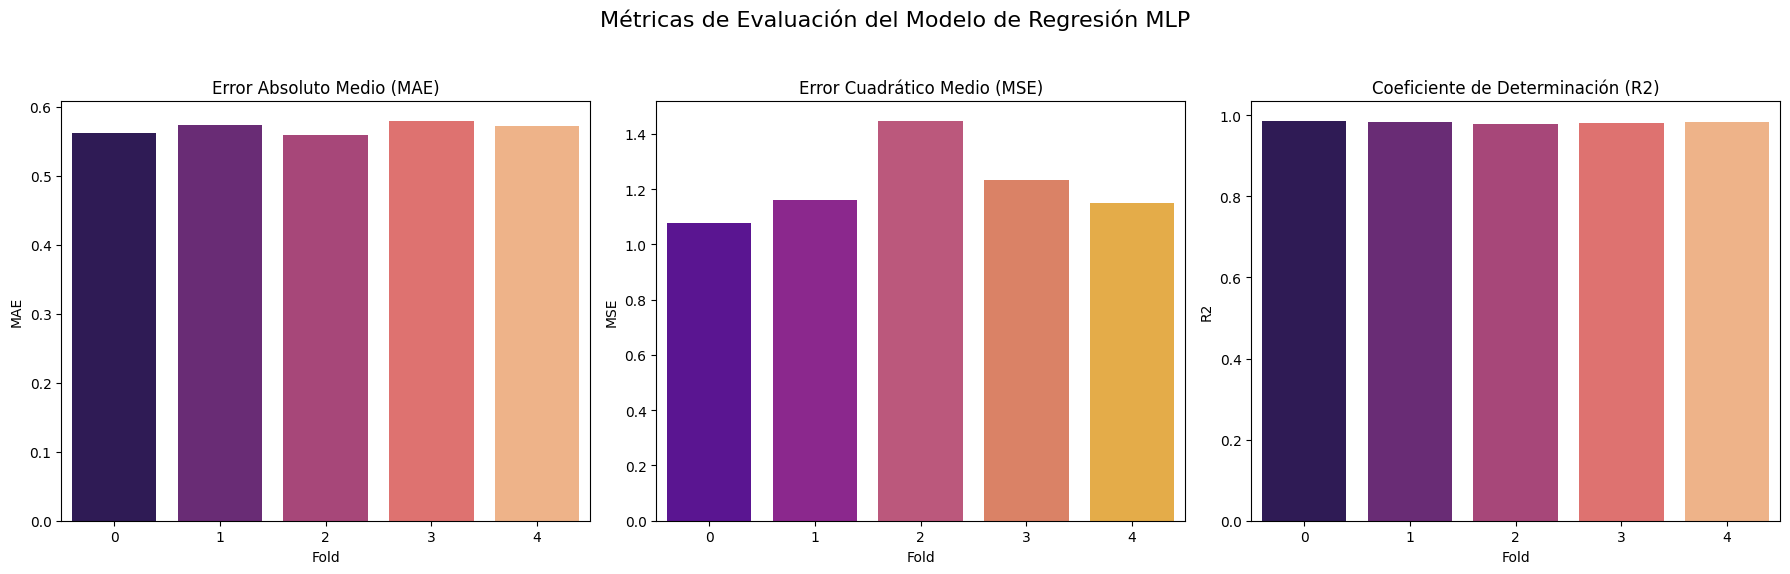

In [ ]:
print("Métricas de validación cruzada para el modelo de regresión:")

print("\nPromedio de las métricas de validación cruzada para el modelo de regresión:")
print(MetricasMultiLayerPerceptron.mean().apply(lambda x: f"{x:.6f}"))

# Visualización de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Métricas de Evaluación del Modelo de Regresión MLP', fontsize=16)

# MAE
seaborn.barplot(x= MetricasMultiLayerPerceptron.index, y=-MetricasMultiLayerPerceptron['test_neg_mean_absolute_error'], ax=axes[0], palette='magma', legend=False)
axes[0].set_title('Error Absoluto Medio (MAE)')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('MAE')
# MSE
seaborn.barplot(x=MetricasMultiLayerPerceptron.index, y=-MetricasMultiLayerPerceptron['test_neg_mean_squared_error'], ax=axes[1], palette='plasma')
axes[1].set_title('Error Cuadrático Medio (MSE)')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('MSE')
# R2
seaborn.barplot(x=MetricasMultiLayerPerceptron.index, y=MetricasMultiLayerPerceptron['test_r2'], ax=axes[2], palette='magma')
axes[2].set_title('Coeficiente de Determinación (R2)')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('R2')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

###Métricas del Modelo de Clasificación (DecisionTreeClassifier) ###


Métricas de validación cruzada para el modelo de clasificación:
Promedio de las métricas de validación cruzada para el modelo de clasificación:
fit_time           0.425993
score_time         0.011054
test_precision     0.991850
train_precision    0.998137
test_recall        0.984241
train_recall       0.994541
test_f1            0.988028
train_f1           0.996335
dtype: object


/tmp/ipython-input-49-3348482405.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=MetricasDecisionTreeClassifier.index, y=MetricasDecisionTreeClassifier['test_precision'], ax=axes[0], palette='viridis')
/tmp/ipython-input-49-3348482405.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=MetricasDecisionTreeClassifier.index, y=MetricasDecisionTreeClassifier['test_recall'], ax=axes[1], palette='plasma')
/tmp/ipython-input-49-3348482405.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.barplot(x=MetricasDecisionTreeClassifier.in

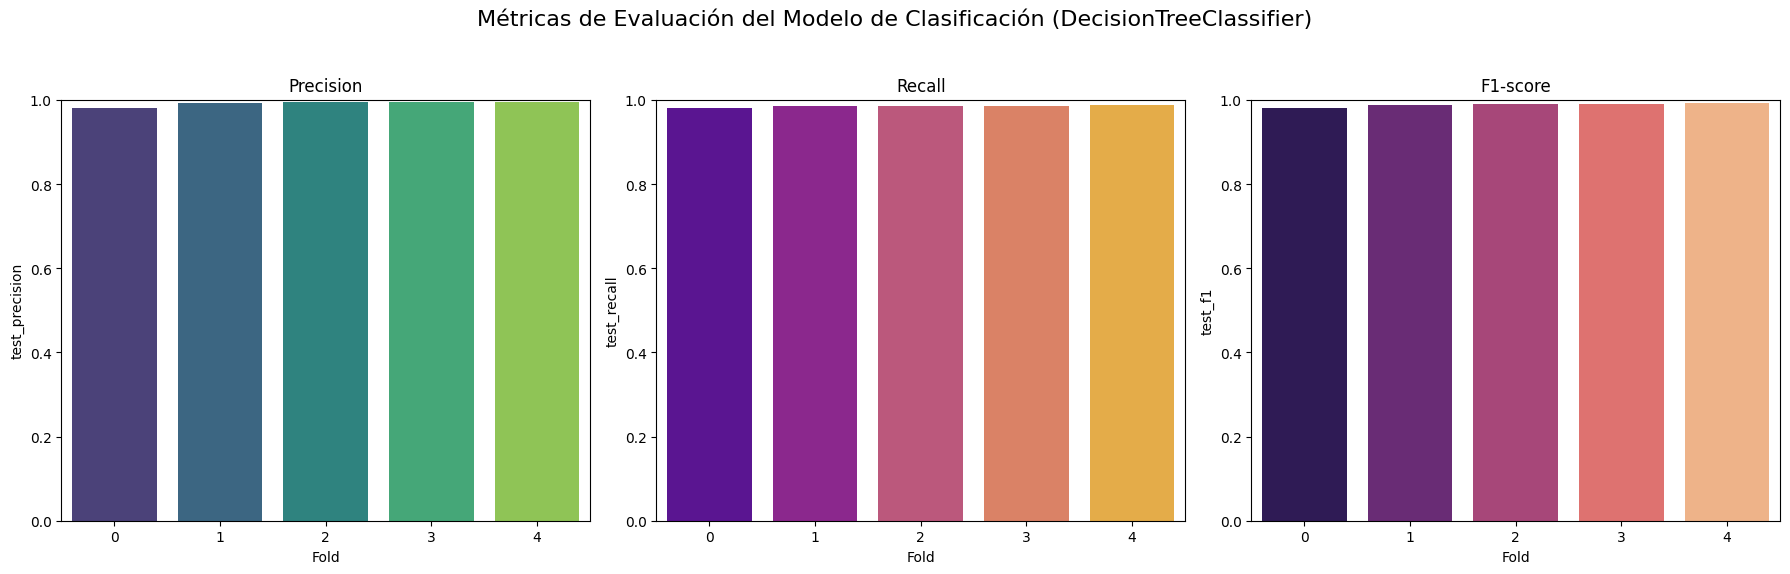

In [ ]:
print("Métricas de validación cruzada para el modelo de clasificación:")

print("Promedio de las métricas de validación cruzada para el modelo de clasificación:")
print(MetricasDecisionTreeClassifier.mean().apply(lambda x: f"{x:.6f}"))


# Visualización de Métricas de Clasificación
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Métricas de evaluación del modelo de clasificación Decision Tree Classifier', fontsize=16)

# Precision
seaborn.barplot(x=MetricasDecisionTreeClassifier.index, y=MetricasDecisionTreeClassifier['test_precision'], ax=axes[0], palette='viridis')
axes[0].set_title('Precision')
axes[0].set_xlabel('Fold')
axes[0].set_ylim(0, 1)

# Recall
seaborn.barplot(x=MetricasDecisionTreeClassifier.index, y=MetricasDecisionTreeClassifier['test_recall'], ax=axes[1], palette='plasma')
axes[1].set_title('Recall')
axes[1].set_xlabel('Fold')
axes[1].set_ylim(0, 1)

# F1-score
seaborn.barplot(x=MetricasDecisionTreeClassifier.index, y=MetricasDecisionTreeClassifier['test_f1'], ax=axes[2], palette='magma')
axes[2].set_title('F1-score')
axes[2].set_xlabel('Fold')
axes[2].set_ylim(0, 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Análisis de Resultados ###

**Análisis del Modelo de Regresión de presiones**

El modelo MLP con multiples salidas demuestra un desempeño aceptable para la estimación de presiones. El coeficiente R2 indica un buena adaptación de los valores estimados por el modelo respecto de los valores originales de presión (R2= 98.2%). Al mismo tiempo, las métricas MAE y MSE evidencian errores de estimación promedio reducidos, con aproximaciones obtenidas en tiempos significatimaente menores a los calculos realizados por simulaciones hidráulicas. La consistencia de las métricas en los distintos folds sugiere que el modelo no presenta un sobreajuste significativo, y generaliza razonablemente bien dado las instancias de entrenamiento.

**Análisis del Modelo de Clasificación**

El modelo DecisionTreeClassifier presenta desempeño robusto, con métricas consistentes para definir la factibilidad de implementación de diseño y operación de EB. La alta precision (0.99) indica que cuando el modelo predice "Factible", es correcto la mayoría de las veces. Un alto Recall (Recall= 0.98) implica que el modelo identifica gran parte de las soluciones factibles reales. El F1-score promeido de 0.98 confirma el buen balance entre ambas métricas. La consistencia de estas métricas a través de los folds indica que el modelo es estable y generaliza bien a los datos de clasificación. Aún es necesario validar su funcionalidad bajo experimentación en algoritmos evolutivos, evaluando su precisión de categorización en los espacios de soluciones no explorados.

**Conclusiones Generales**

Ambos modelos de Machine Learning presentan estimaciones fiables ante datos no presentes en el entrenamiento de acuerdo a las métricas obtenidas en la validación cruzada. Los parámetros de los modelos tambien han sido optimizados mediante una busqueda en rejilla con reducción progresiva, lo que resulta en  modelos aptos a los datos sintéticos.

Los resultados obtenidos sugieren que esta aproximación de dos capas tiene potencial para reemplazar o complementar las simulaciones hidráulicas en la evaluación rápida de soluciones para problemas de diseño y operación de redes de distribución de agua. Existen limitaciones y factores clave que afectan a los modelos como la variación de la base sintética, sobretodo en un caso de estudio con grandes espacios de soluciones.  

Para una evaluación completa, es necesario experimentar con el prototipo de sistema de doble capa en un proceso de evaluación como parte de un algoritmo evolutivo. Esto permitiría validar su rendimiento en condiciones operativas reales y consolidar su aplicabilidad como herramientas de apoyo en procesos de diseño y toma de decisiones en redes hidráulicas.